In [1]:
import ee
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geetools
import eemont
import geemap
from ee_extra.TimeSeries.core import getTimeSeriesByRegion

from plot_ee_fctns import get_image_index, box_around_point, mask_other, initialise_comparison
from masks import mask_MODIS_clouds, MODIS_Mask_QC, mask_s2_clouds, mask_s2_clouds_collection, csPlus_mask_collection, MODIS_mask_clouds_250m
import masks

# Path to the private key file
key_path = 'Access/ee-martinparker637-e68fde65abb4.json'

# Load the service account credentials
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=['https://www.googleapis.com/auth/earthengine'])

# Initialize Earth Engine with the service account credentials
ee.Initialize(credentials)
root_directory = ''

In [20]:
#dataset = ee.Image('https://zenodo.org/records/10640528/files/CTM_GER_2017_rst_v202_COG.tif?download=1')
dataset = ee.Image('projects/ee-martinparker637/assets/CTM_GER_2021_rst_v202_COG')

In [23]:
dataset.propertyNames().getInfo()

['system:time_start',
 'system:footprint',
 'system:time_end',
 'system:version',
 'system:id',
 'system:asset_size',
 'system:bands',
 'system:band_names']

/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


KeyboardInterrupt: 

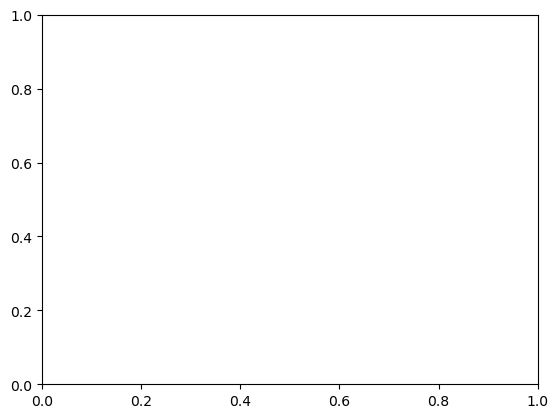

In [22]:
classification = dataset.select('b1')
Maize_DE_map = classification.eq(91).Or(classification.eq(92))
region = ee.Geometry.Point(9, 50).buffer(500)
Maize_DE_map.geetools.plot(bands=['b1'], region=region, crs = 'EPSG:3035')

In [2]:
def initialise_comparison(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                          coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0],
                          country = 'DE', crop_type = 'M', year = 2019, root_directory = '', 
                          combine_eujrc = False, just_eujrc = False,
                          buffer_size = 1500, mask_scale = 10, indices = True, spectral_indices = ['EVI','NDVI', 'SAVI', 'NDWI', 'CIG']):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    grid_cell_lon = coord[1]
    grid_cell_lat = coord[0]
    f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size),{'ID':'A'})
    f1c = ee.FeatureCollection([f1])
    IC = (ee.ImageCollection(instrument)
         .filterBounds(f1c)
         .filterDate(f'{year}-01-01',f'{year}-12-31'))
    if indices:
        IC = IC.spectralIndices(spectral_indices)
    if instrument == 'COPERNICUS/S1_GRD':
        IC = IC.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) # Ensure VV polarization is available
        IC = IC.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) # Ensure VH polarization is available
        IC = IC.filter(ee.Filter.eq('instrumentMode', 'IW')) # Select only Interferometric Wide (IW) mode images
        IC = IC.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) # Filter ascending orbit images
    grid_cell = ee.Geometry.Point(grid_cell_lon, grid_cell_lat).buffer(buffer_size).bounds()
    world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').map(mask_other)
    if just_eujrc:
        eujrc = ee.ImageCollection('JRC/D5/EUCROPMAP/V1').select(['classification']).filterDate('2018-01-01', '2023-01-01').mosaic()
        crop = eujrc.select('classification').eq(216)
        crop = crop.updateMask(crop)
    elif combine_eujrc:
        eujrc = ee.ImageCollection('JRC/D5/EUCROPMAP/V1').select(['classification']).filterDate('2018-01-01', '2023-01-01').mosaic()
        eujrc_maize = eujrc.select('classification').eq(216)
        #Take out update mask if you want just worldcereals
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().updateMask(eujrc_maize).select('classification').gt(0)
    else:
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
    region = crop.clip(grid_cell).geometry()
    vectors = crop.reduceToVectors(**{
        'geometry': region,
        'scale': mask_scale,
        'maxPixels': 1e13,
        'bestEffort':True,
        'eightConnected': False,
        })#.map(lambda x: x.buffer(-20))
    return IC, vectors

In [23]:
def compare_veg_indices(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8, 10, 11]],
                      country = 'DE', crop_type = 'M', year = 2021, root_directory = '', N=1, reducer_code = 'median',
                      mask_scale=10, buffer_size=1500, bands = ['EVI','NDVI', 'SAVI', 'NDWI', 'CIG'], indices = False):
    fig, axs = plt.subplots(len(coords), 1, figsize = (6, len(coords)*3))
    for coord_index, coord in enumerate(coords):
        print(f'coordinate {coord_index + 1}')
        IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                            country = country, crop_type = crop_type, 
                                            year = year, root_directory = root_directory,
                                           mask_scale=10, buffer_size=buffer_size, #mask_scale
                                           spectral_indices = bands, indices = indices)
        vectors = vectors.map(lambda feat: feat.buffer(-50))
        if instrument == 'COPERNICUS/S2_SR_HARMONIZED':
            masked = csPlus_mask_collection(IC)
        elif instrument == "MODIS/061/MOD09GQ":
            masked = MODIS_mask_clouds_250m(IC)
        random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
        ts = getTimeSeriesByRegion(masked,
            reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
            geometry = random_points,#ee.Geometry.Point([coord[1], coord[0]]).buffer(500),#
            bands = bands,#['B4','B8'],
            scale = mask_scale)
        x = geemap.ee_to_df(ts)
        x = x.where(x[bands[0]]>=0).dropna()
        if instrument == "MODIS/061/MOD09GQ":
            x['NDVI'] = (x['sur_refl_b02'] - x['sur_refl_b01'])/(x['sur_refl_b02'] + x['sur_refl_b01'])
            bands_to_plot = bands + ['NDVI']
        elif instrument == 'COPERNICUS/S2_SR_HARMONIZED':
            bands_to_plot = bands
        for VI_index, veg_index in enumerate(['NDVI']): #enumerate(bands_to_plot):
            x['date'] = pd.to_datetime(x['date'])
            if np.isin('NDVI', bands) == False:
                x = x.where(x[bands[0]]!=-9999).dropna()
            else:
                x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            colour = ['blue', 'red', 'green', 'black', 'purple'][VI_index]
            line_style = ['solid', 'solid', 'dotted', 'dashed', 'dashdot'][VI_index]
            if coord_index == 0:
                axs[coord_index].plot(xreduced['date'], (xreduced[veg_index]),#/np.max([1, np.abs(xreduced[veg_index]).max()]))*np.sign( xreduced[veg_index].max()),
                                      c = colour, label = veg_index, linestyle = line_style)
            else:
                axs[coord_index].plot(xreduced['date'], (xreduced[veg_index]),#/np.max([1, np.abs(xreduced[veg_index]).max()]))*np.sign( xreduced[veg_index].max()),
                                      c = colour,  linestyle = line_style)
        axs[coord_index].set_title('Comparing different VIs')
        axs[coord_index].tick_params(labelrotation=45)
        #axs[coord_index].set_ylim([0, 1])
    fig.legend()
    fig.tight_layout()
    return x

coordinate 1
coordinate 2
coordinate 3
coordinate 4
coordinate 5


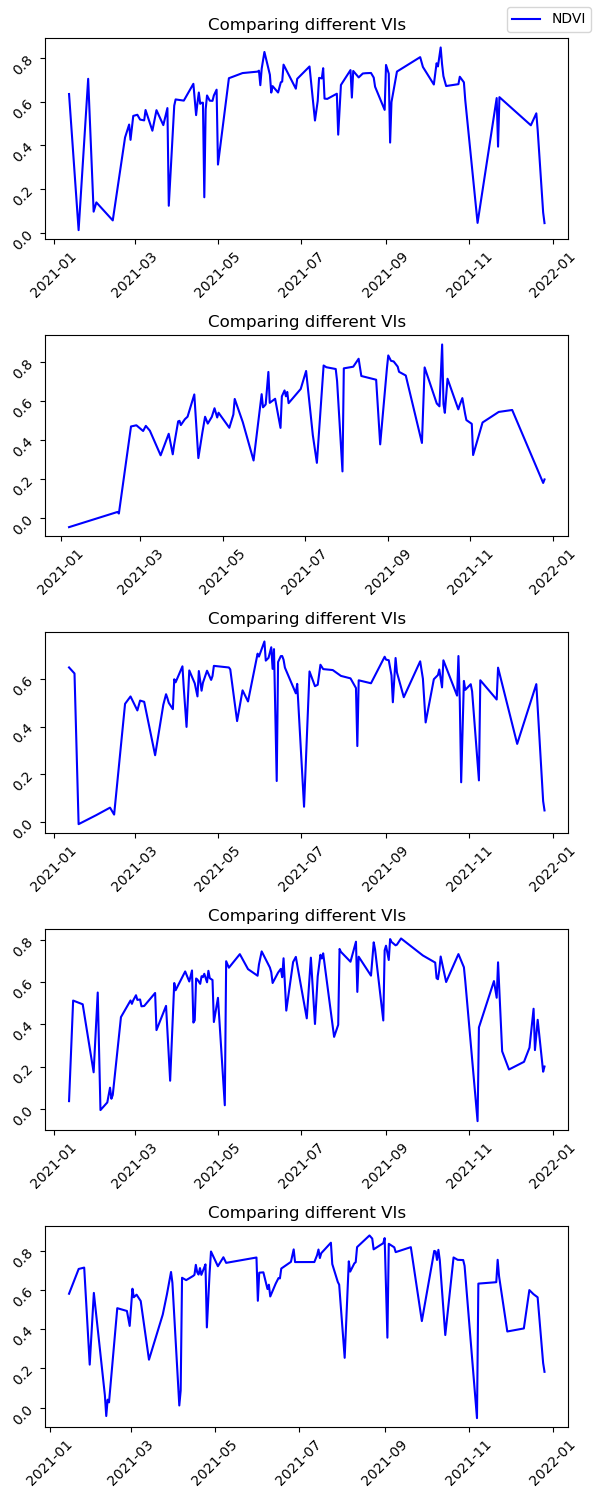

In [24]:
x = compare_veg_indices(instrument = "MODIS/061/MOD09GQ",#MODIS/006/MOD09GQ
                    reducer_code = 'median', mask_scale = 500, buffer_size=1500, N=1500, crop_type = 'M',
                   bands = ['sur_refl_b01','sur_refl_b02'], year=2021)#'SAVI' , 'NBR', 'GVMI', 'CIG'

coordinate 1
coordinate 2
coordinate 3
coordinate 4
coordinate 5


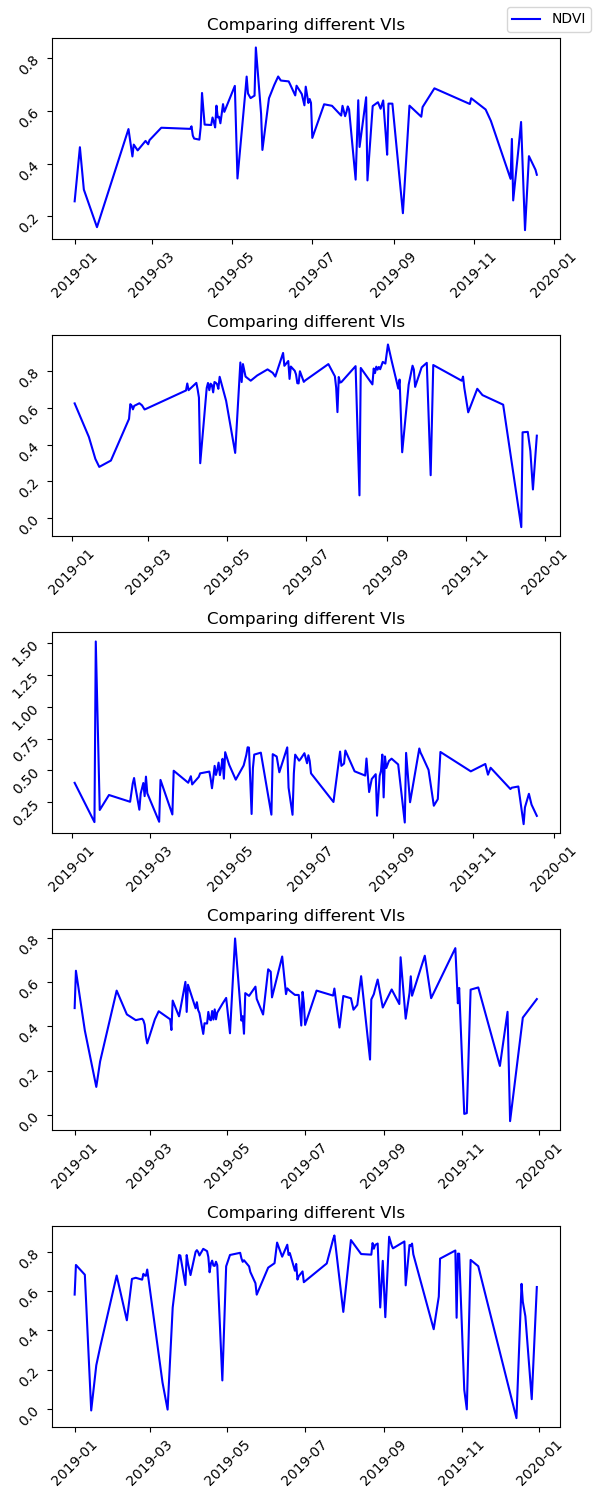

In [11]:
Kenya_coords = dtype =  np.loadtxt(root_directory + "Saved_files/station_coords_Kenya.csv", {'names': ('lat', 'lon', 'region', 'west', 'south', 'east', 'north'),
                     'formats': ('f8', 'f8', 'S20', 'f8', 'f8', 'f8', 'f8')})
x = compare_veg_indices(instrument = "MODIS/061/MOD09GQ",#MODIS/006/MOD09GQ
                    reducer_code = 'median', mask_scale = 500, buffer_size=1500, N=1500, crop_type = 'M',
                   bands = ['sur_refl_b01','sur_refl_b02'])#'SAVI' , 'NBR', 'GVMI', 'CIG'

In [21]:
def MODIS_QC_collection(IC):
    return IC.map(MODIS_Mask_QC)

def MODIS_cloud_collection(IC):
    return IC.map(mask_MODIS_clouds)

In [22]:
def compare_cloud_masks(instrument = 'COPERNICUS/S2_SR_HARMONIZED', 
                                 coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[2],
                                 country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                                reducer_code = 'median', N=1, mask_scale=10, buffer_size=1500, 
                        bands = ['EVI','NDVI', 'SAVI', 'NDWI', 'CIG'], indices = False):
    IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                        country = country, crop_type = crop_type, 
                                        year = year, root_directory = root_directory,
                                       indices = indices, spectral_indices = bands)
    fig, ax = plt.subplots()
    if instrument == 'COPERNICUS/S2_SR_HARMONIZED':
        masks = [mask_s2_clouds_collection, csPlus_mask_collection]
        name_choices = ['s2 cloud mask', 'google cloud mask']
    elif instrument == "MODIS/061/MOD09GA":
        masks = [MODIS_QC_collection, MODIS_cloud_collection]
        name_choices = ['QC band', 'cloud band']
    elif instrument == "MODIS/061/MOD09GQ":
        masks = [MODIS_mask_clouds_250m]
        name_choices = ['cloud band 500m']
    for index, masker in enumerate(masks):
        mask_name = name_choices[index]
        print(f'compute for {mask_name}')
        masked = masker(IC)
        random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
        ts = getTimeSeriesByRegion(masked,
            reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
            geometry = random_points,
            bands = bands,#['EVI','NDVI'],#['B4','B8'],
            scale = mask_scale)
        x = geemap.ee_to_df(ts)
        x['date'] = pd.to_datetime(x['date'])
        x = x.where(x[bands[0]]!=-9999).dropna()
        xreduced = x.where(x['reducer'] == reducer_code).dropna()
        if instrument == "MODIS/061/MOD09GA" or instrument == "MODIS/061/MOD09GQ":
            xreduced['NDVI'] = (xreduced['sur_refl_b02'] - xreduced['sur_refl_b01'])/(xreduced['sur_refl_b02'] + xreduced['sur_refl_b01'])
        ax.plot(xreduced['date'], xreduced['NDVI'], label = f'{name_choices[index]}, {reducer_code} reduced')
    fig.legend()
                                 

compute for cloud band 500m


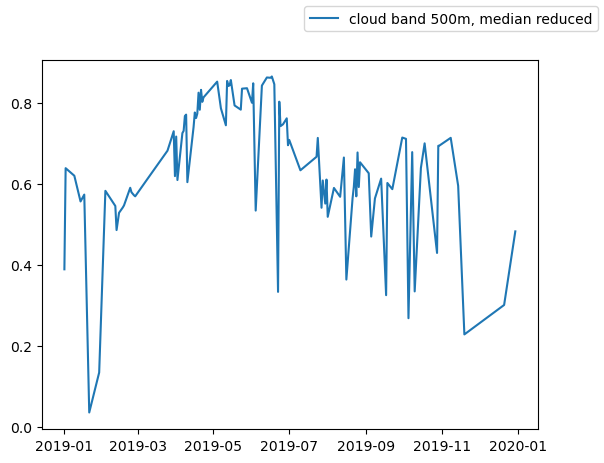

In [61]:
compare_cloud_masks(instrument = "MODIS/061/MOD09GQ",#"MODIS/061/MOD09GA",#MODIS/006/MOD09GQ
                    reducer_code = 'median', mask_scale = 1000, buffer_size=5000, crop_type = 'M',
                   bands = ['sur_refl_b01','sur_refl_b02'])#'SAVI' , 'NBR', 'GVMI', 'CIG'

In [11]:
x

,date,reducer,sur_refl_b01,sur_refl_b02


coordinate 1
coordinate 2
coordinate 3
coordinate 4
coordinate 5
coordinate 6
coordinate 7
coordinate 8
coordinate 9
coordinate 10


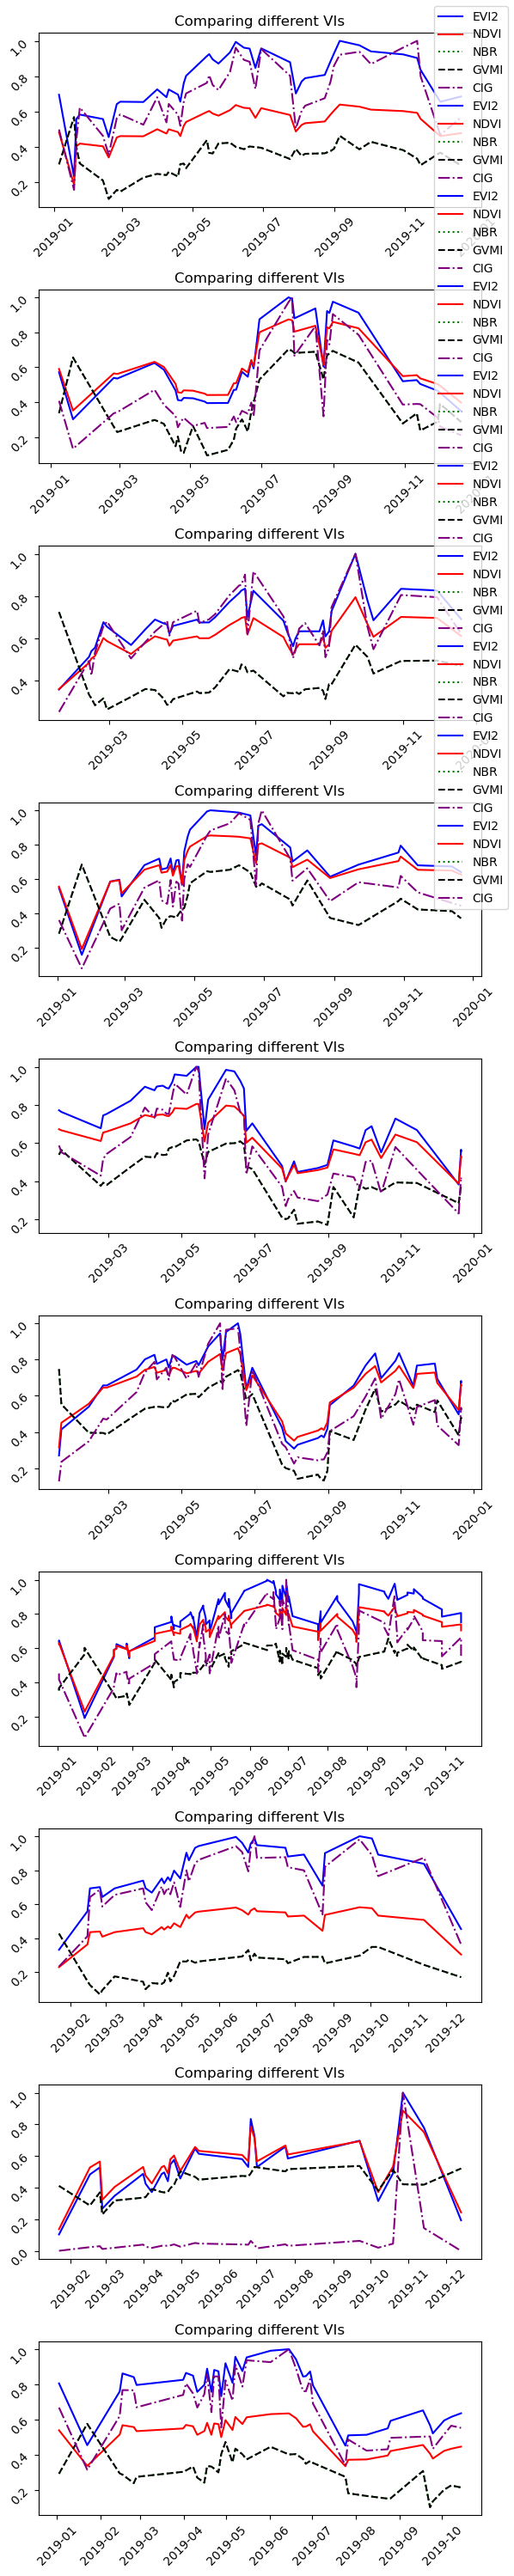

In [14]:
Kenya_coords = dtype =  np.loadtxt(root_directory + "Saved_files/station_coords_Kenya.csv", {'names': ('lat', 'lon', 'region', 'west', 'south', 'east', 'north'),
                     'formats': ('f8', 'f8', 'S20', 'f8', 'f8', 'f8', 'f8')})
compare_veg_indices(reducer_code = 'mean', mask_scale = 500, buffer_size=5000, crop_type = 'M',
                   bands = ['EVI2','NDVI', 'NBR', 'GVMI', 'CIG'])#'SAVI'

In [6]:
def compare_veg_indices(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                      mask_scale=10, buffer_size=1500, bands = ['EVI','NDVI', 'SAVI', 'NDWI', 'CIG']):
    fig, axs = plt.subplots(len(coords), 1, figsize = (10, 15))
    for coord_index, coord in enumerate(coords):
        print(f'coordinate {coord_index + 1}')
        IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                            country = country, crop_type = crop_type, 
                                            year = year, root_directory = root_directory,
                                           mask_scale=mask_scale, buffer_size=buffer_size,
                                           spectral_indices = bands)
        masked = csPlus_mask_collection(IC)
        random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
        ts = getTimeSeriesByRegion(masked,
            reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
            geometry = random_points,
            bands = bands,#['B4','B8'],
            scale = mask_scale)
        x = geemap.ee_to_df(ts)
        for VI_index, veg_index in enumerate(bands):
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            colour = ['blue', 'red', 'green', 'black', 'purple'][VI_index]
            line_style = ['solid', 'solid', 'dotted', 'dashed', 'dashdot'][VI_index]
            axs[coord_index].plot(xreduced['date'], (xreduced[veg_index]/np.max([1, np.abs(xreduced[veg_index]).max()]))*np.sign( xreduced[veg_index].max()),
                                  c = colour, label = veg_index, linestyle = line_style)
        axs[coord_index].set_title('Comparing different VIs')
        axs[coord_index].tick_params(labelrotation=45)
        #axs[coord_index].set_ylim([0, 1])
    fig.legend()
    fig.tight_layout()

coordinate 1
coordinate 2
coordinate 3
coordinate 4
coordinate 5


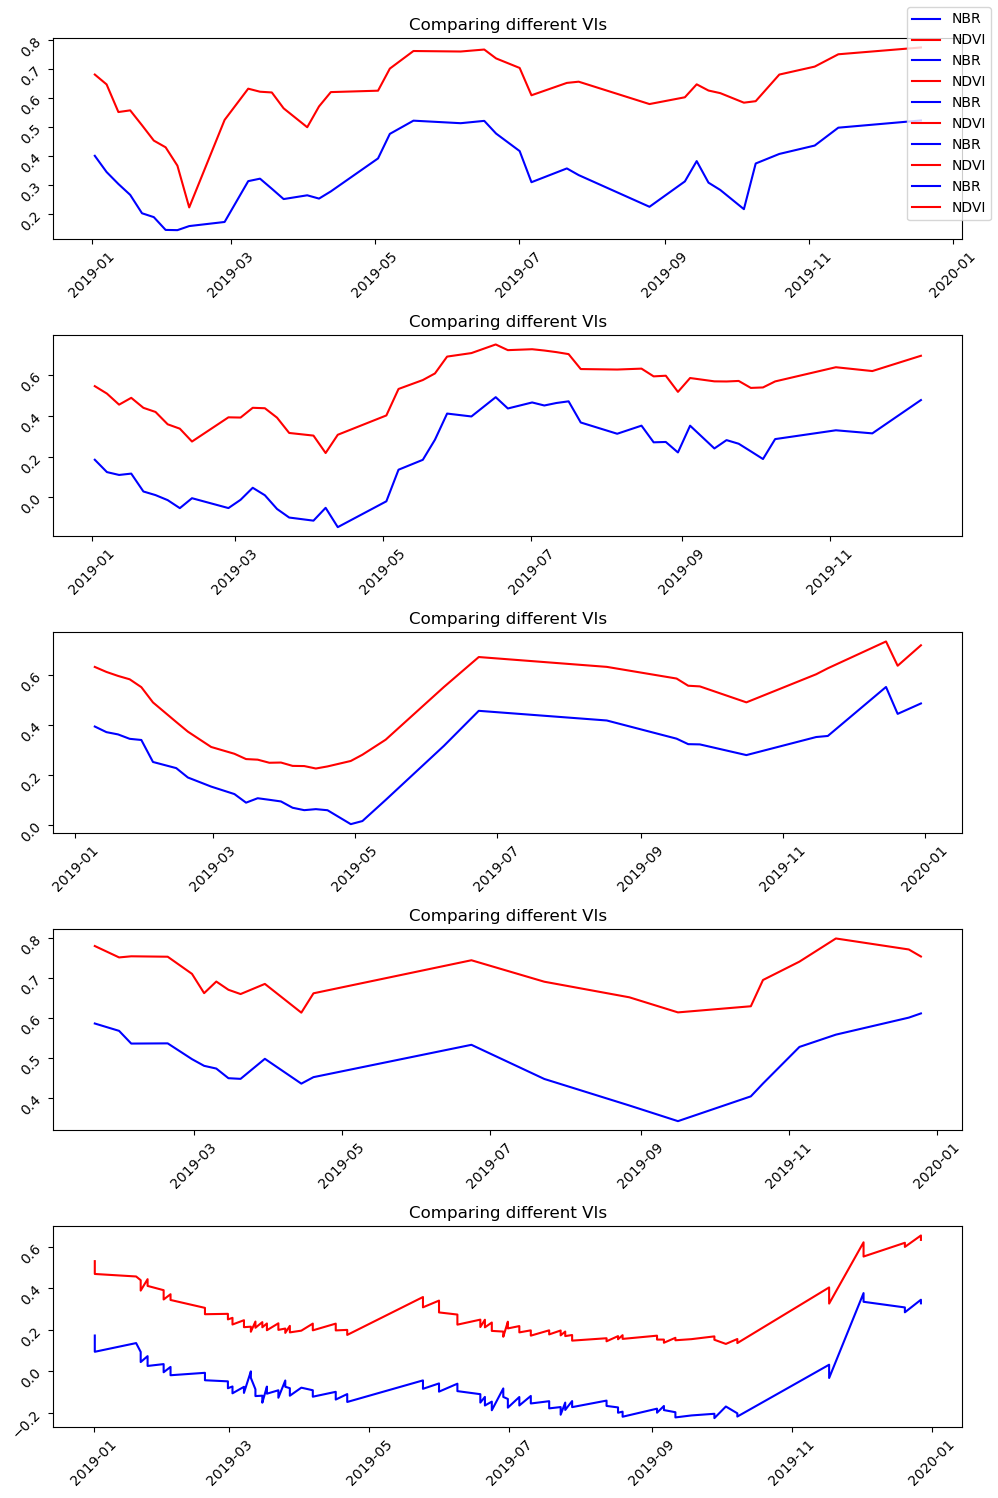

In [13]:
Kenya_coords = dtype =  np.loadtxt(root_directory + "Saved_files/station_coords_Kenya.csv", {'names': ('lat', 'lon', 'region', 'west', 'south', 'east', 'north'),
                     'formats': ('f8', 'f8', 'S20', 'f8', 'f8', 'f8', 'f8')})
compare_veg_indices(reducer_code = 'mean', coords = Kenya_coords[[0, 2, 4, 6, 13]], mask_scale = 500, buffer_size=5000, crop_type = 'M',
                   bands = ['NBR', 'NDVI'])#['EVI2','NDVI', 'NBR', 'GVMI', 'CIG'])#'SAVI'

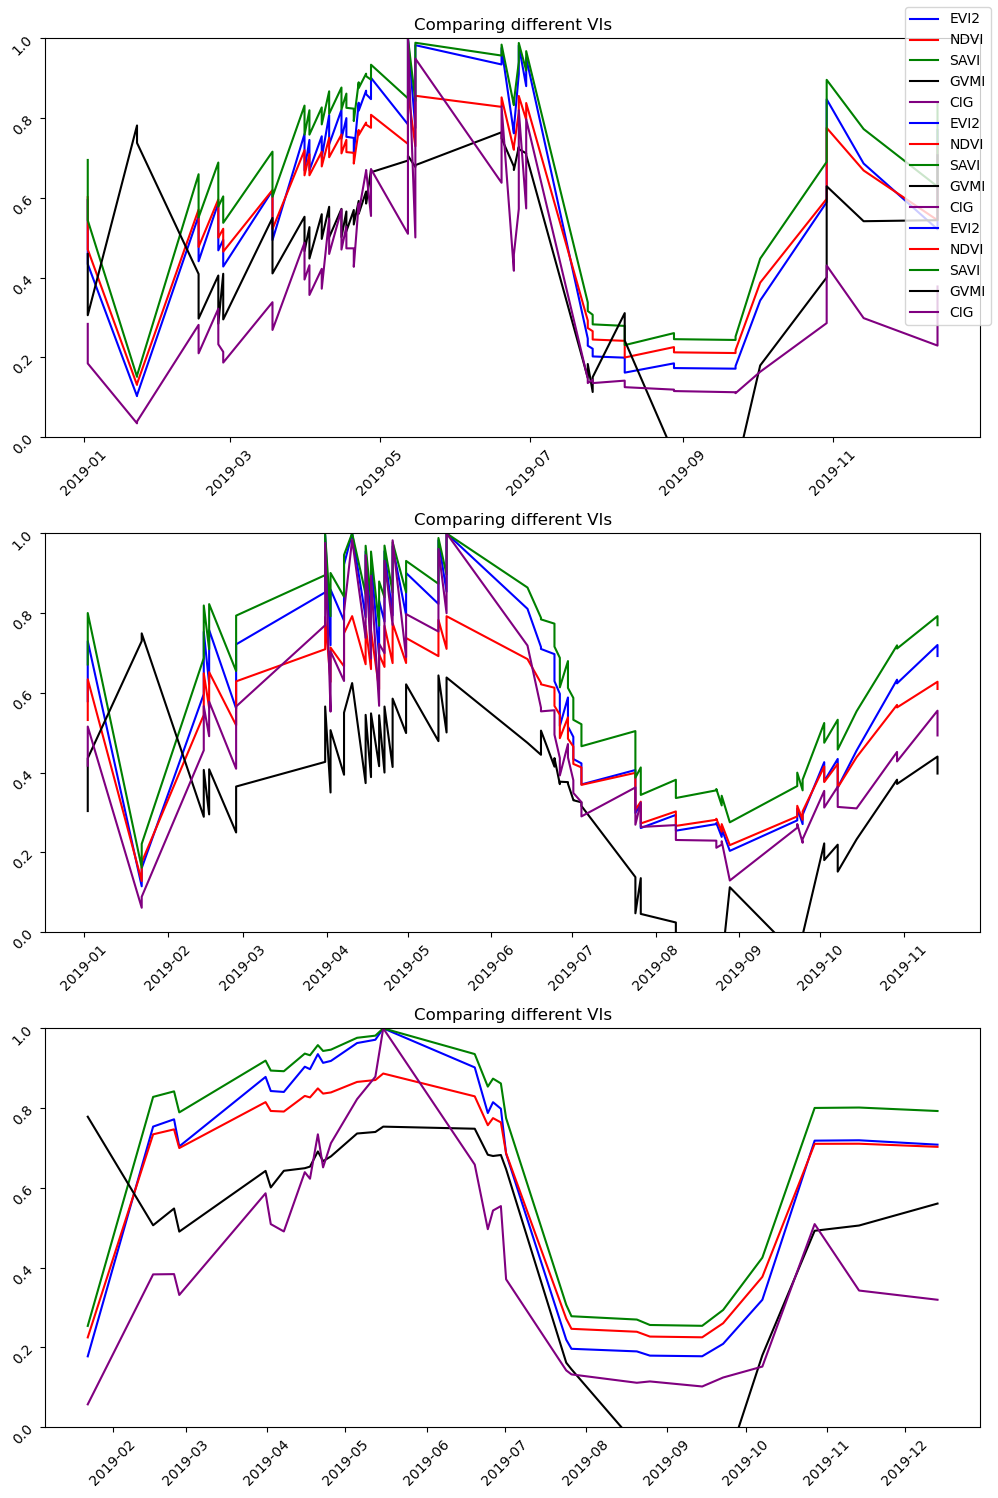

In [175]:
compare_veg_indices(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[3, 6, 8]], mask_scale = 500, buffer_size=5000, crop_type = 'M',
                   bands = ['EVI2','NDVI', 'SAVI', 'GVMI', 'CIG'])

In [176]:
#compare_veg_indices(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[3, 6, 8]], mask_scale = 500, buffer_size=5000, crop_type = 'M',
#                   bands = ['NDVI', 'BNDVI', 'EVI2','CVI', 'CIG'])

In [177]:
#compare_veg_indices(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[3, 6, 8]], mask_scale = 500, buffer_size=5000, crop_type = 'M',
#                   bands = ['NDVI', 'GARI', 'GBNDVI','GLI', 'GNDVI'])

In [178]:
#compare_veg_indices(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[3, 6, 7, 8, 9]], mask_scale = 500, buffer_size=5000, crop_type = 'M',
#                   bands = ['NDVI', 'GVMI', 'RVI', 'SAVI', 'VARI'], year=2020)

In [7]:
def compare_crop_masks(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:2],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                      mask_scale=10, buffer_size=1500):
    fig, axs = plt.subplots(1, 3, figsize = (20, 10))
    for mask_index in range(3):
        first_coord = True
        for coord in coords:
            print(coord)
            if mask_index == 0:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            elif mask_index == 1:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory, just_eujrc = True,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            elif mask_index == 2:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory, combine_eujrc = True,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            masked = csPlus_mask_collection(IC)
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
            ts = getTimeSeriesByRegion(masked,
                reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
                geometry = random_points,
                bands = ['EVI','NDVI'],#['B4','B8'],
                scale = mask_scale)
            try:
                x = geemap.ee_to_df(ts)
            except:
                continue
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            name_choices = ['s2 cloud mask', 'google cloud mask']
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            colour = ['blue', 'red', 'green'][mask_index]
            if first_coord:
                mask_name = ['World cereal',
                             'EUJRC',
                             'World cereal and EUJRC'][mask_index]
                axs[mask_index].plot(xreduced['date'], xreduced['NDVI'], 
                                     alpha = 0.5, c = colour,
                                     label = f'Using {mask_name} crop masks, {reducer_code} reduced')
                first_coord = False
            else:
                axs[mask_index].plot(xreduced['date'], xreduced['NDVI'], 
                         alpha = 0.5, c=colour)
            axs[mask_index].set_title(mask_name)
            axs[mask_index].tick_params(labelrotation=45)
    fig.legend()
    fig.tight_layout()

[  54.3167   10.05   7504.    ]
[  54.4333    9.8167 7521.    ]
[  54.4       8.7667 7532.    ]
[  54.3167   10.05   7504.    ]
[  54.4333    9.8167 7521.    ]
[  54.4       8.7667 7532.    ]
[  54.3167   10.05   7504.    ]
[  54.4333    9.8167 7521.    ]
[  54.4       8.7667 7532.    ]


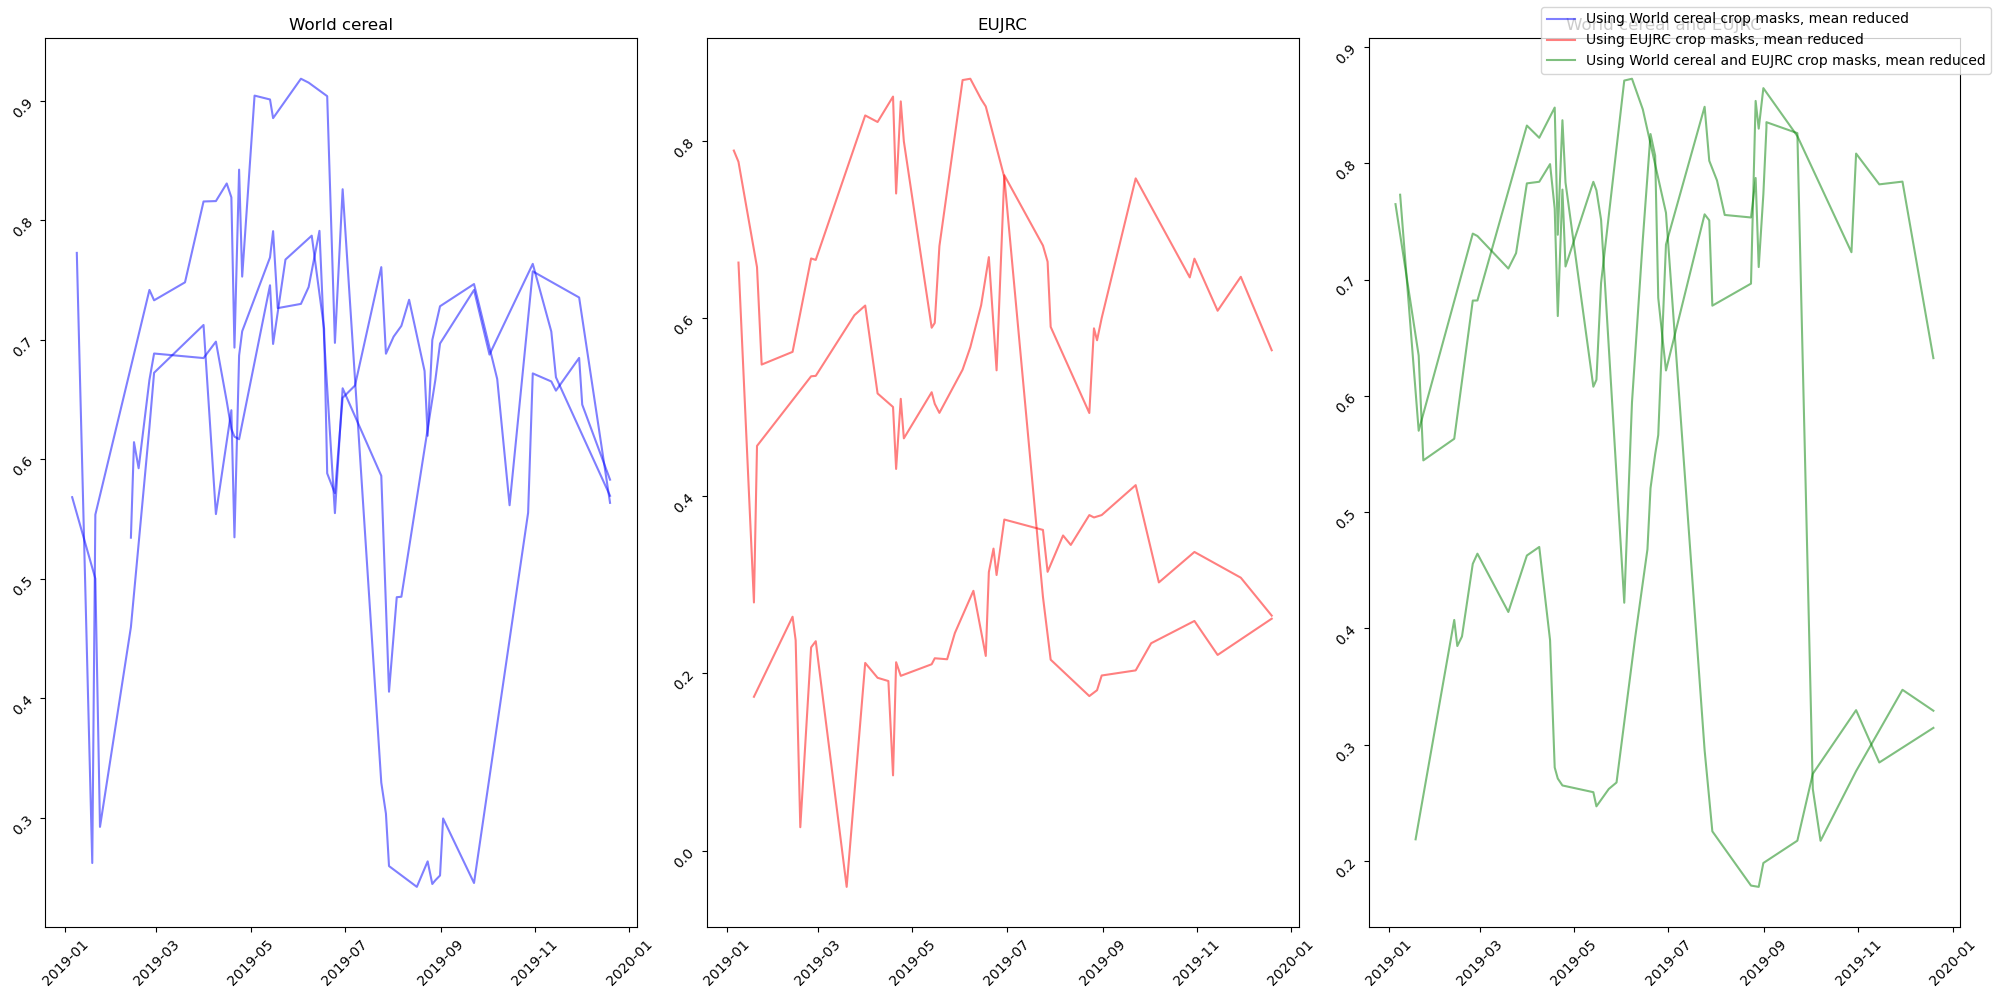

In [7]:
compare_crop_masks(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3], mask_scale = 500, buffer_size=5000, crop_type = 'ww')

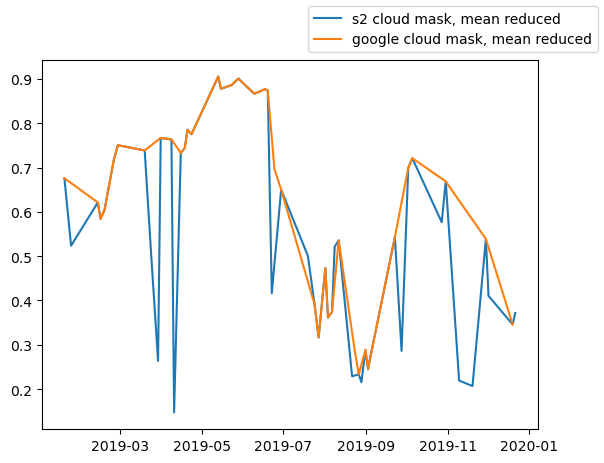

In [17]:
compare_cloud_masks(reducer_code = 'mean', coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[2])

In [8]:
def compare_reducers(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=200,
                     reducer_code = 'median'):
    fig, ax = plt.subplots()
    IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory,
                                                buffer_size = 10000)
    masked = csPlus_mask_collection(IC)
    random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
    
    ts = getTimeSeriesByRegion(masked,
        reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
        geometry = random_points,
        bands = ['EVI','NDVI'],#['B4','B8'],
        scale = 10)
    x = geemap.ee_to_df(ts)
    x['date'] = pd.to_datetime(x['date'])
    x = x.where(x['NDVI']!=-9999).dropna()
    xmean = x.where(x['reducer'] == 'mean').dropna()
    xmedian = x.where(x['reducer'] == 'median').dropna()
    xmax = x.where(x['reducer'] == 'max').dropna()
    name_choices = ['s2 cloud mask', 'google cloud mask']
    ax.plot(xmean['date'], xmean['NDVI'], label = f'google cloud mask, mean reduced')
    ax.plot(xmedian['date'], xmedian['NDVI'], label = f'google cloud mask, median reduced')
    ax.plot(xmax['date'], xmax['NDVI'], label = f'google cloud mask, max reduced')
    fig.legend()

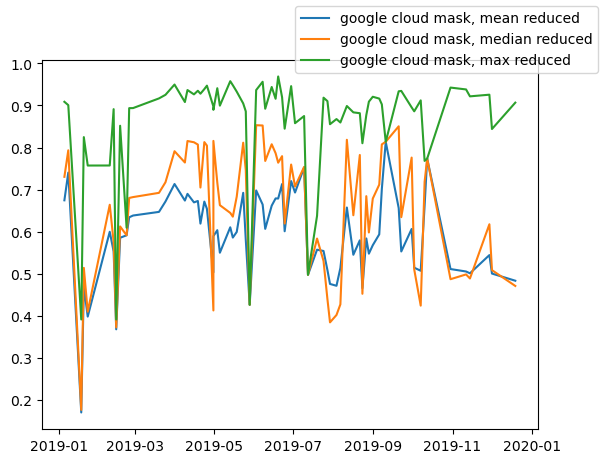

In [14]:
compare_reducers(N=400)

In [9]:
def compare_sample_sizes(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:5],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median'):
    fig, ax = plt.subplots(len(coords), 1, figsize = (10, 5))
    for coord_index, coord in enumerate(coords):
        print(f'Coordinate {coord_index + 1}')
        IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory)
        for N in range(1, 50, 10):
            masked = csPlus_mask_collection(IC)
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 43, 'maxError': 1})#
            ts = getTimeSeriesByRegion(masked,
                reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
                geometry = random_points,
                bands = ['EVI','NDVI'],#['B4','B8'],
                scale = 10)
            x = geemap.ee_to_df(ts)
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            ax[coord_index].plot(xreduced['date'], xreduced['NDVI'], label = f'Google cloud mask, {reducer_code} reduced')
        if coord_index == 0:
            fig.legend()

Coordinate 0
Coordinate 1
Coordinate 2


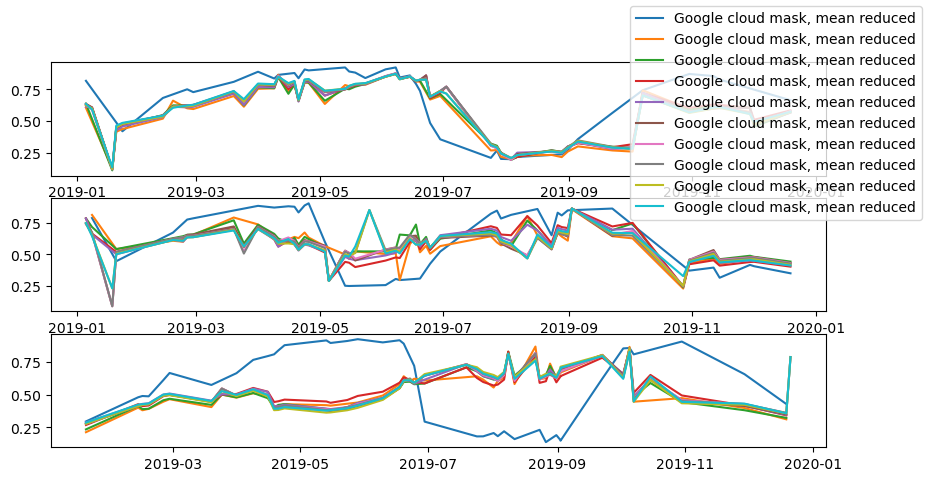

In [158]:
compare_sample_sizes(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3])

In [10]:
def addNDVI(image):
    nir = image.select('sur_refl_b02');
    red = image.select('sur_refl_b01');
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI');
    return image.addBands(ndvi)

In [13]:
def count_reducer(img):
    return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                maxPixels=160, bestEffort=True)
def addNDVI(image, bands = ['sur_refl_b02', 'sur_refl_b01']):
    ndvi = image.normalizedDifference(bands).rename('NDVI')
    return image.addBands([ndvi])
def resample_linear(ds):
    ds['date'] = pd.to_datetime(pd.to_datetime(ds['date'], format='%Y-%m-%d-%H-%M-%S').dt.date)
    ds.set_index('date', inplace=True)
    ds = ds[~ds.index.duplicated()]
    ds= ds.resample('D').asfreq()#.infer_objects(copy=False)
    ds.loc[:, ds.columns != 'reducer']  = ds.loc[:, ds.columns != 'reducer'].interpolate()
    ds.reset_index(inplace=True)
    return ds

In [16]:
def compare_images2(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                   buffer_size = 3000, count_threshold = 15, mask_
                     reducer_code = 'median', bands = ['NDVI', 'EVI2'], indices = False, 
                   masker = csPlus_mask_collection):
    country_codes = {'DE': 93,
                         'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size),{'ID':'A'})
    f1c = ee.FeatureCollection([f1])
    IC = (ee.ImageCollection("MODIS/061/MOD09GQ")
         .filterBounds(f1c)
         .filterDate(f'{year}-01-01',f'{year}-12-31'))
    IC = MODIS_mask_clouds_250m(IC)
    world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').map(mask_other)
    crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
    crop = crop.updateMask(crop)
    crop = crop.setDefaultProjection(world_cereals.first().select('classification').projection(), scale = 10)
    crop = count_reducer(crop).gt(count_threshold)
    #print(crop.bandNames().getInfo())
    region = mask_other(crop.clip(f1))#.geometry())#.geometry()
    IC = IC.map(lambda img: img.updateMask(region))
    IC = IC.map(addNDVI)
    grid_cell_lon = coord[1]
    grid_cell_lat = coord[0]
    location = ee.Geometry.Point(grid_cell_lon, grid_cell_lat).buffer(buffer_size)
    fig, axs = plt.subplots(4, 5, figsize = (24, 60))
    for index in range(20):#20
        img2ndImage=get_image_index(IC, index)
        img2ndImage.geetools.plot(bands = ['NDVI'], ax = axs[index // 5, index % 5], region=location,cmap="viridis",
                              color="k")
    fig.savefig('manyplots.jpg')

In [17]:
compare_images2()

NameError: name 'count_threshold' is not defined

In [12]:
def compare_images(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                   buffer_size = 3000,
                     reducer_code = 'median', bands = ['NDVI', 'EVI2'], indices = False, 
                   masker = csPlus_mask_collection):
    IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                        country = country, crop_type = crop_type, 
                                        year = year, root_directory = root_directory,
                                       spectral_indices = bands, indices = indices)
    masked = masker(IC)# (IC)
    #IC = IC.filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',50)
    if instrument == "MODIS/061/MOD09GQ":
        masked = masked.map(addNDVI)
    #location = box_around_point(coord, 0.1)
    grid_cell_lon = coord[1]
    grid_cell_lat = coord[0]
    location = ee.Geometry.Point(grid_cell_lon, grid_cell_lat).buffer(buffer_size)
    fig, axs = plt.subplots(4, 5, figsize = (24, 60))
    for index in range(20):#20
        img2ndImage=get_image_index(masked, index)
        img2ndImage.geetools.plot(bands = ['NDVI'], ax = axs[index // 5, index % 5], region=location,cmap="viridis",
                              color="k")
    fig.savefig('manyplots.jpg')

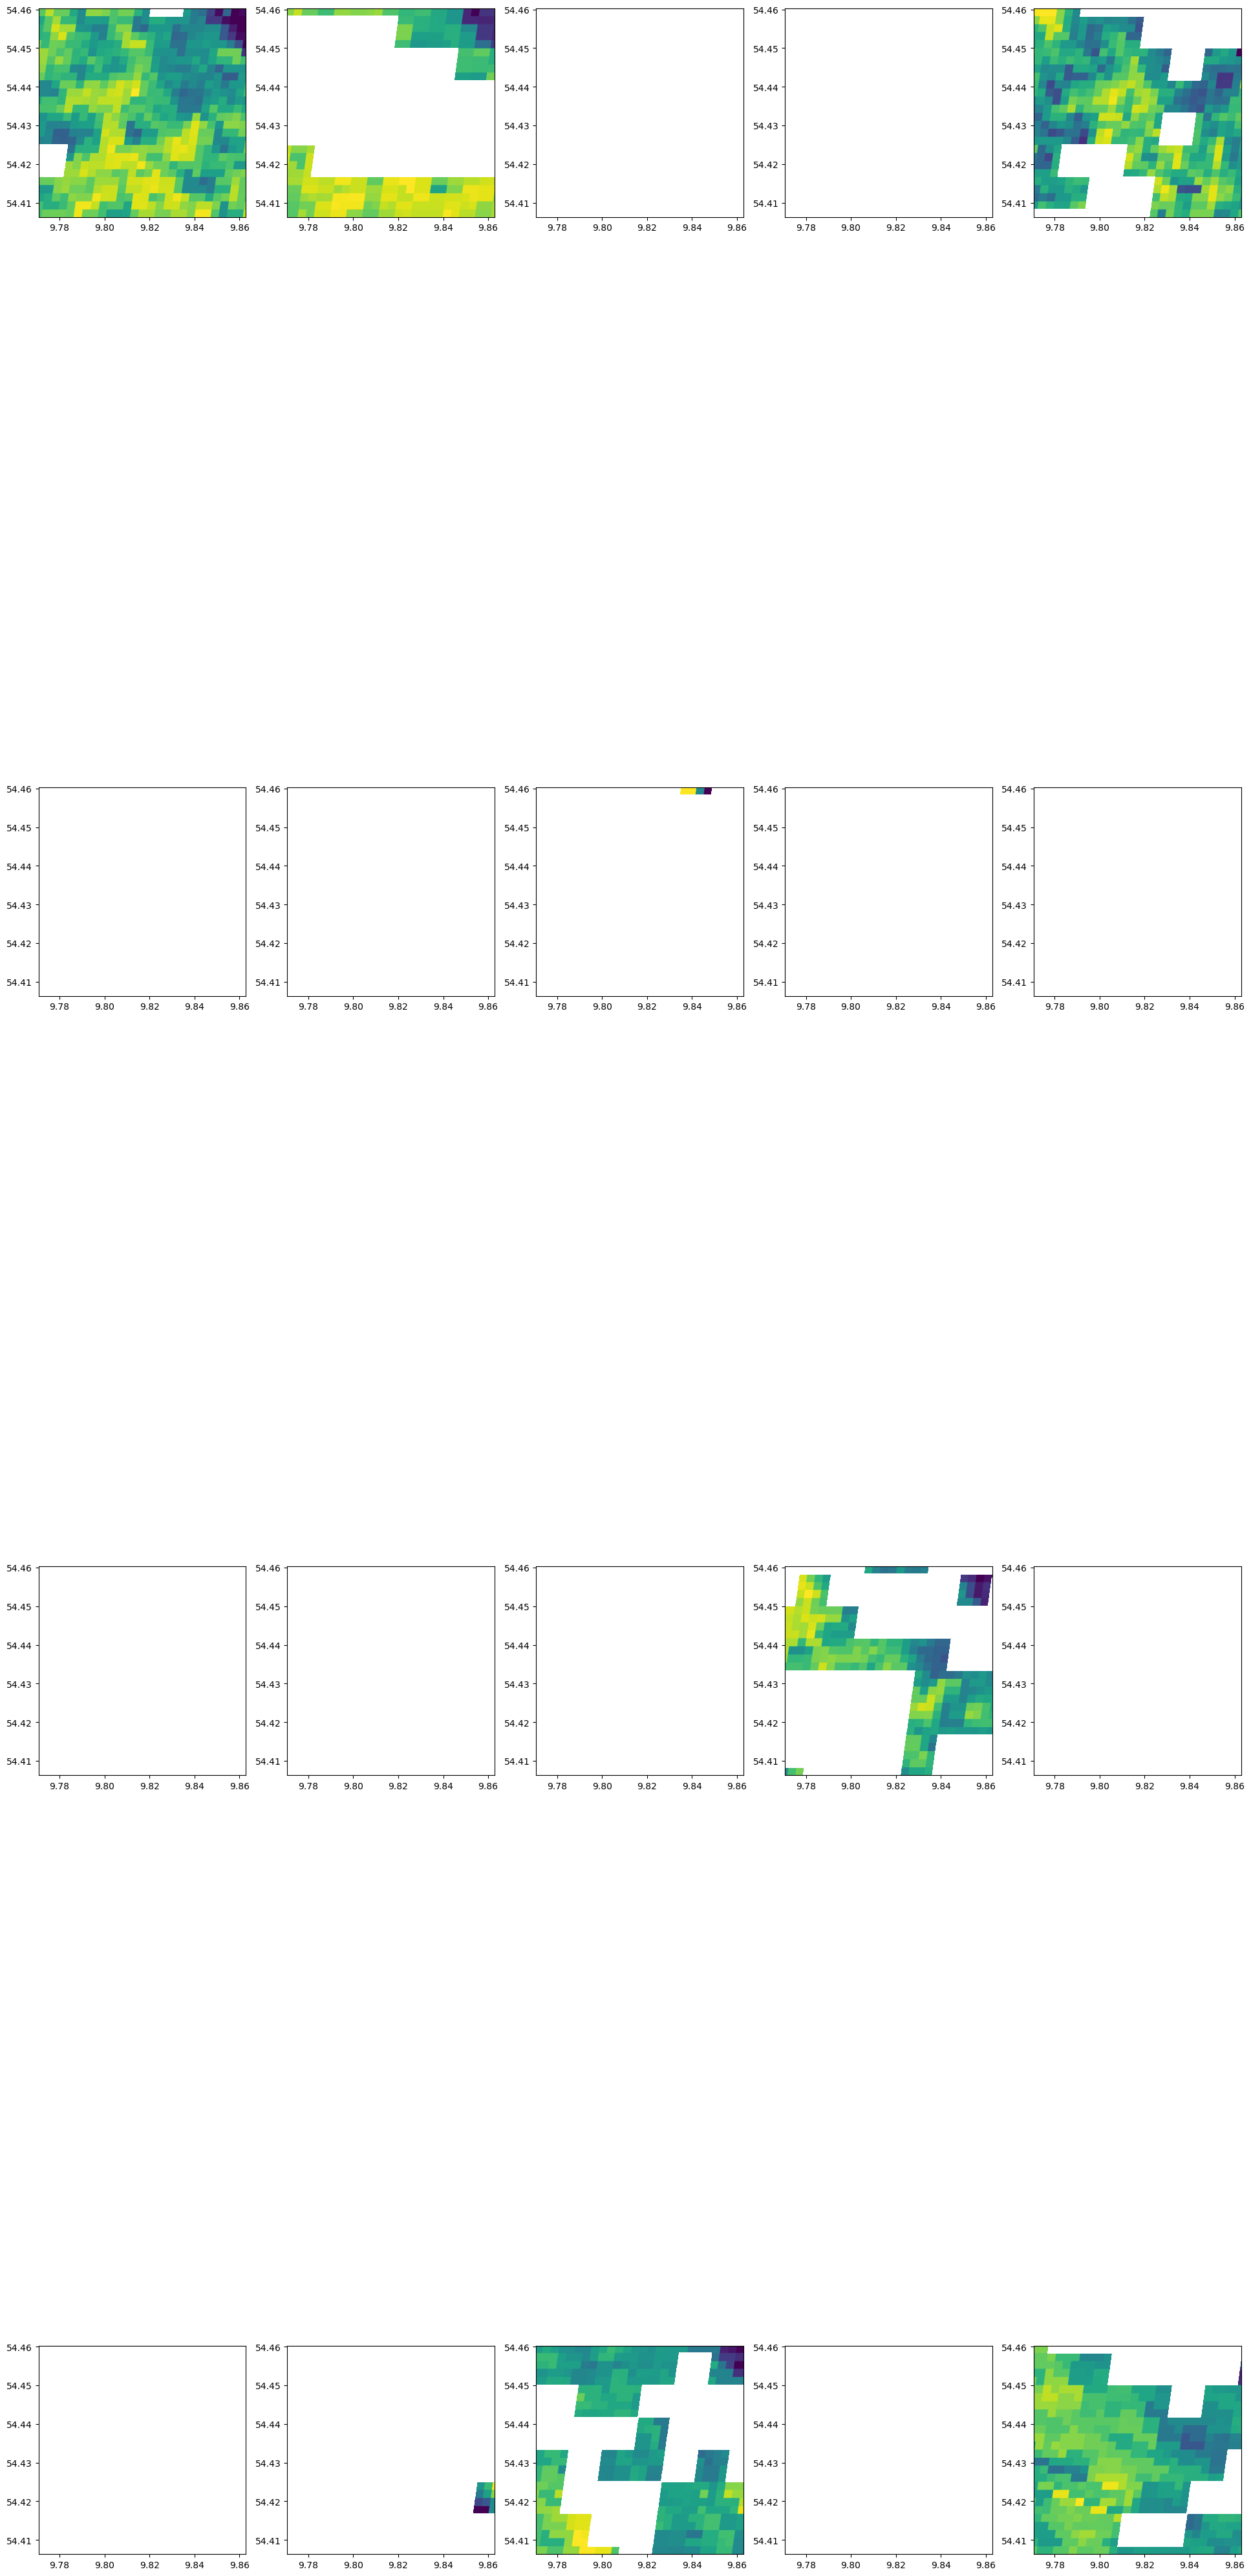

In [12]:
compare_images(instrument = "MODIS/061/MOD09GQ",
              bands = ['sur_refl_b01', 'sur_refl_b02'], masker = MODIS_mask_clouds_250m)

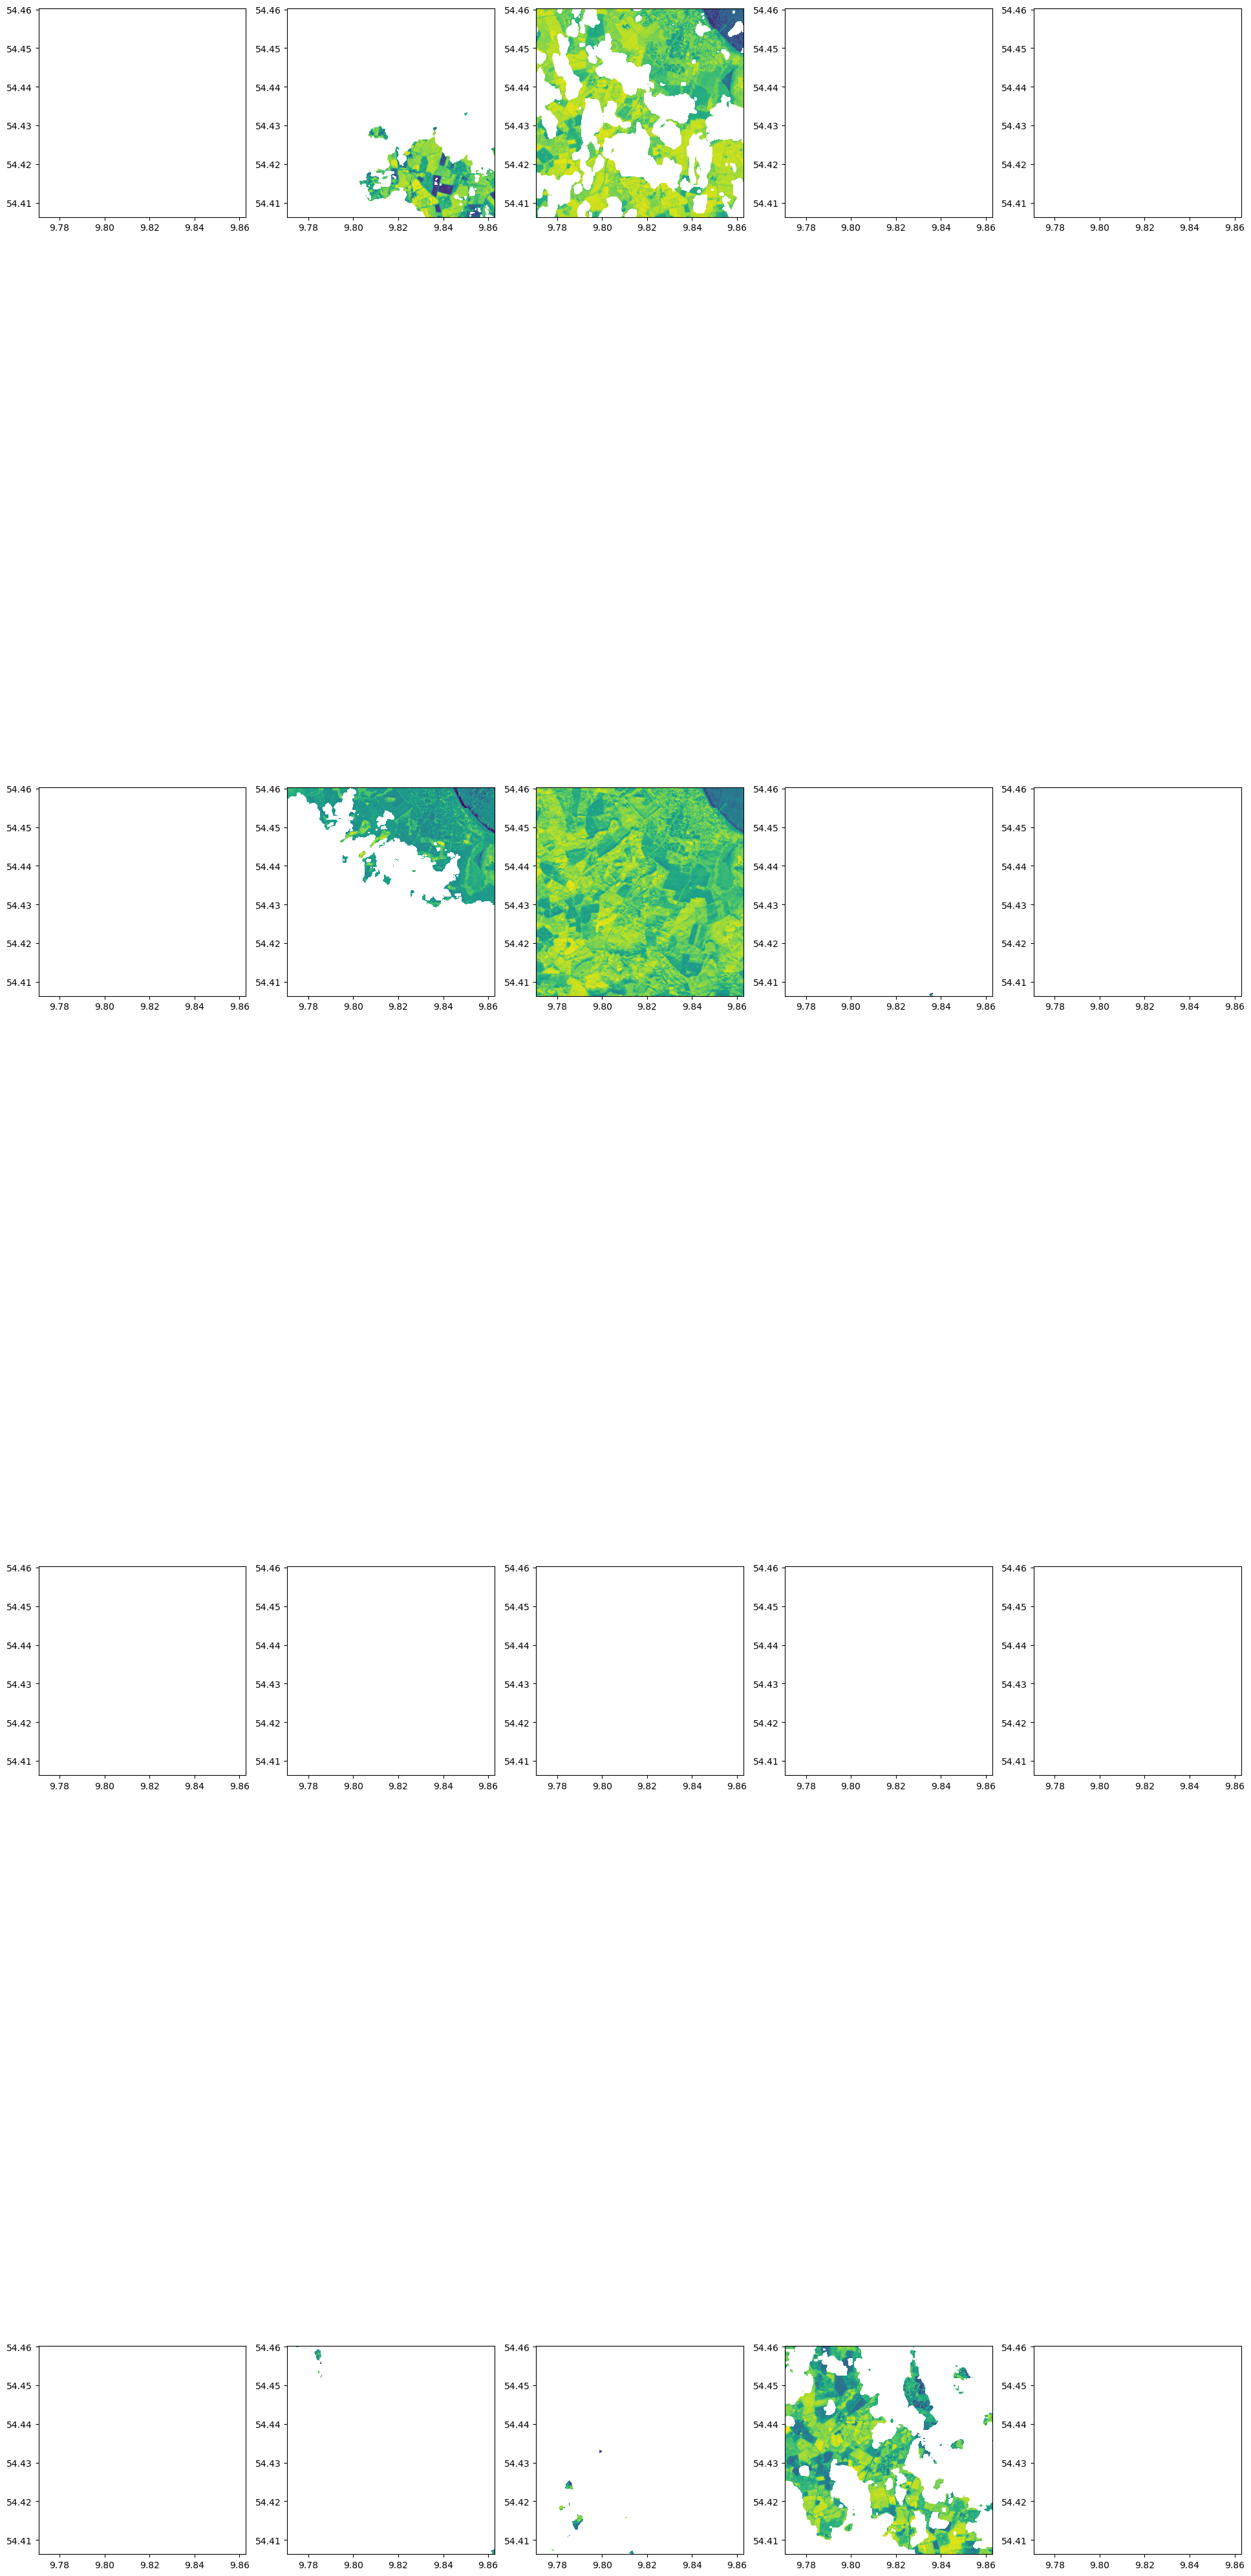

In [16]:
compare_images(indices=True)